![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

# 3. Training and Reusing Named Entity Recognition Models

## Related blogposts and videos:

https://towardsdatascience.com/named-entity-recognition-ner-with-bert-in-spark-nlp-874df20d1d77

NerDL worksghop (90 min): https://www.youtube.com/watch?v=YM-e4eOiQ34

https://medium.com/spark-nlp/named-entity-recognition-for-healthcare-with-sparknlp-nerdl-and-nercrf-a7751b6ad571

https://medium.com/atlas-research/ner-for-clinical-text-7c73caddd180

In [0]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *

print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

spark

Spark NLP version 4.2.0
Apache Spark version: 3.1.2
Out[1]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.1.2 
 Master 
 spark://10.139.64.5:7077 
 AppName 
 Databricks Shell

### CoNLL Data Prep

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/src/test/resources/conll2003/eng.train
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/src/test/resources/conll2003/eng.testa

In [0]:
with open("eng.train") as f:
    train_txt =f.read()

print (train_txt[:500])

-DOCSTART- -X- -X- O

EU NNP B-NP B-ORG
rejects VBZ B-VP O
German JJ B-NP B-MISC
call NN I-NP O
to TO B-VP O
boycott VB I-VP O
British JJ B-NP B-MISC
lamb NN I-NP O
. . O O

Peter NNP B-NP B-PER
Blackburn NNP I-NP I-PER

BRUSSELS NNP B-NP B-LOC
1996-08-22 CD I-NP O

The DT B-NP O
European NNP I-NP B-ORG
Commission NNP I-NP I-ORG
said VBD B-VP O
on IN B-PP O
Thursday NNP B-NP O
it PRP B-NP O
disagreed VBD B-VP O
with IN B-PP O
German JJ B-NP B-MISC
advice NN I-NP O
to TO B-PP O
consumers NNS B-NP

In [0]:
from sparknlp.training import CoNLL

training_data = CoNLL().readDataset(spark, 'file:/databricks/driver/eng.train')

training_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 text| document| sentence| token| pos| label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
EU rejects German...|[{document, 0, 47...|[{document, 0, 47...|[{token, 0, 1, EU...|[{pos, 0, 1, NNP,...|[{named_entity, 0...|
 Peter Blackburn|[{document, 0, 14...|[{document, 0, 14...|[{token, 0, 4, Pe...|[{pos, 0, 4, NNP,...|[{named_entity, 0...|
 BRUSSELS 1996-08-22|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 7, BR...|[{pos, 0, 7, NNP,...|[{named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows

In [0]:
training_data.printSchema()

root
-- text: string (nullable = true)
-- document: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- sentence: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- token: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- pos: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- label: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)

In [0]:
%time training_data.count()

CPU times: user 25.9 ms, sys: 16 ms, total: 42 ms
Wall time: 11.3 s
Out[13]: 14041

In [0]:
import pyspark.sql.functions as F

training_data.select(F.explode(F.arrays_zip(training_data.token.result, 
                                            training_data.pos.result, 
                                            training_data.label.result)).alias("cols")) \
             .select(F.expr("cols['0']").alias("token"),
                     F.expr("cols['1']").alias("pos"),
                     F.expr("cols['2']").alias("ner_label")).show(truncate=50)

+----------+---+---------+
 token|pos|ner_label|
+----------+---+---------+
 EU|NNP| B-ORG|
 rejects|VBZ| O|
 German| JJ| B-MISC|
 call| NN| O|
 to| TO| O|
 boycott| VB| O|
 British| JJ| B-MISC|
 lamb| NN| O|
 .| .| O|
 Peter|NNP| B-PER|
 Blackburn|NNP| I-PER|
 BRUSSELS|NNP| B-LOC|
1996-08-22| CD| O|
 The| DT| O|
 European|NNP| B-ORG|
Commission|NNP| I-ORG|
 said|VBD| O|
 on| IN| O|
 Thursday|NNP| O|
 it|PRP| O|
+----------+---+---------+
only showing top 20 rows

In [0]:
training_data.select(F.explode(F.arrays_zip(training_data.token.result,
                                            training_data.label.result)).alias("cols")) \
             .select(F.expr("cols['0']").alias("token"),
                     F.expr("cols['1']").alias("ground_truth")).groupBy('ground_truth').count().orderBy('count', ascending=False).show(100,truncate=False)

+------------+------+
ground_truth|count |
+------------+------+
O |169578|
B-LOC |7140 |
B-PER |6600 |
B-ORG |6321 |
I-PER |4528 |
I-ORG |3704 |
B-MISC |3438 |
I-LOC |1157 |
I-MISC |1155 |
+------------+------+

In [0]:
# You can use any word embeddings you want (Glove, Elmo, Bert, custom etc.)

glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d')\
          .setInputCols(["document", "token"])\
          .setOutputCol("embeddings")

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[ | ][OK!]

### Create Graph

We will use `TFNerDLGraphBuilder` annotator to create a graph in the model training pipeline. This annotator inspects the data and creates the proper graph if a suitable version of TensorFlow (<= 2.7 ) is available. The graph is stored in the defined folder and loaded by the approach.

**ATTENTION:** Do not forget to play with the parameters of this annotator, it may affect the model performance that you want to train.

**Licensed users** would use this module to create **custom graphs** for each DL model (`ner_dl`, `generic_classifier`, `assertion_dl`, `relation_extraction`) in Spark NLP.

In [0]:
%fs mkdirs file:/dbfs/ner_logs

res3: Boolean = true

In [0]:
%fs mkdirs file:/dbfs/ner_graphs

res4: Boolean = true

In [0]:
graph_folder = "/dbfs/ner_graphs"

graph_builder = TFNerDLGraphBuilder()\
              .setInputCols(["sentence", "token", "embeddings"]) \
              .setLabelColumn("label")\
              .setGraphFile("auto")\
              .setGraphFolder(graph_folder)\
              .setHiddenUnitsNumber(20)

In [0]:
nerTagger = NerDLApproach()\
              .setInputCols(["sentence", "token", "embeddings"])\
              .setLabelColumn("label")\
              .setOutputCol("ner")\
              .setMaxEpochs(3)\
              .setLr(0.003)\
              .setBatchSize(32)\
              .setRandomSeed(0)\
              .setVerbose(1)\
              .setValidationSplit(0.2)\
              .setEvaluationLogExtended(True) \
              .setEnableOutputLogs(True)\
              .setIncludeConfidence(True)\
              .setGraphFolder(graph_folder)\
              .setOutputLogsPath('dbfs:/ner_logs') # if not set, logs will be written to ~/annotator_logs
          #   .setEnableMemoryOptimizer(True) # if not set, logs will be written to ~/annotator_logs
    
ner_pipeline = Pipeline(stages=[glove_embeddings,
                                graph_builder,
                                nerTagger])


### Fitting

In [0]:
ner_model = ner_pipeline.fit(training_data)

# 1 epoch takes around 1.5 min with batch size=32
# if you get an error for incompatible TF graph, use 4.1 NerDL-Graph.ipynb notebook to create a graph (or see the bottom cell of this notebook)

Ner DL Graph Builder configuration:
Graph folder: /dbfs/ner_graphs
Graph file name: auto
Build params: {'ntags': 9, 'embeddings_dim': 100, 'nchars': 85, 'lstm_size': 20}

In [0]:
%sh cd /dbfs/ner_logs && ls


NerDLApproach_6abfac1f2415.log

In [0]:
%sh head -n 45 /dbfs/ner_logs/NerDLApproach_*

Name of the selected graph: /dbfs/ner_graphs/blstm_9_100_20_85.pb
Training started - total epochs: 3 - lr: 0.003 - batch size: 32 - labels: 9 - chars: 84 - training examples: 11203


Epoch 1/3 started, lr: 0.003, dataset size: 11203


Epoch 1/3 - 16.90s - loss: 1972.0533 - batches: 353
Quality on validation dataset (20.0%), validation examples = 2240
time to finish evaluation: 1.55s
label tp fp fn prec rec f1
B-LOC 1315 389 134 0.7717136 0.90752244 0.83412623
I-ORG 521 121 277 0.8115265 0.6528822 0.7236112
I-MISC 85 36 165 0.70247936 0.34 0.45822102
I-LOC 150 69 96 0.6849315 0.6097561 0.64516133
I-PER 914 103 21 0.89872175 0.97754014 0.9364754
B-MISC 475 108 238 0.81475127 0.66619915 0.7330247
B-ORG 914 257 366 0.78052944 0.7140625 0.745818
B-PER 1289 184 92 0.8750849 0.9333816 0.90329367
tp: 5663 fp: 1267 fn: 1389 labels: 8
Macro-average prec: 0.7924673, rec: 0.72516805, f1: 0.75732553
Micro-average prec: 0.8171717, rec: 0.8030346, f1: 0.8100414


Epoch 2/3 started, lr: 0.0029850747, dataset size: 11203


Epoch 2/3 - 13.68s - loss: 758.52454 - batches: 353
Quality on validation dataset (20.0%), validation examples = 2240
time to finish evaluation: 1.17s
label tp fp fn prec rec f1
B-LOC 1269 132 180 0.90578157 0.8757764 0.8905263
I-ORG 619 178 179 0.77666247 0.77568924 0.7761755
I-MISC 129 58 121 0.6898396 0.516 0.59038895
I-LOC 160 31 86 0.8376963 0.6504065 0.7322655
I-PER 912 63 23 0.93538463 0.97540104 0.9549738
B-MISC 529 79 184 0.8700658 0.7419355 0.80090845
B-ORG 1081 287 199 0.7902047 0.84453124 0.81646526
B-PER 1287 113 94 0.9192857 0.9319334 0.9255663
tp: 5986 fp: 941 fn: 1066 labels: 8
Macro-average prec: 0.8406151, rec: 0.78895915, f1: 0.8139684
Micro-average prec: 0.86415476, rec: 0.8488372, f1: 0.8564275


Epoch 3/3 started, lr: 0.0029702971, dataset size: 11203

In [0]:
from sparknlp.training import CoNLL

test_data = CoNLL().readDataset(spark, 'file:/databricks/driver/eng.testa')

test_data = glove_embeddings.transform(test_data)

test_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 text| document| sentence| token| pos| label| embeddings|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
CRICKET - LEICEST...|[{document, 0, 64...|[{document, 0, 64...|[{token, 0, 6, CR...|[{pos, 0, 6, NNP,...|[{named_entity, 0...|[{word_embeddings...|
 LONDON 1996-08-30|[{document, 0, 16...|[{document, 0, 16...|[{token, 0, 5, LO...|[{pos, 0, 5, NNP,...|[{named_entity, 0...|[{word_embeddings...|
West Indian all-r...|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 3, We...|[{pos, 0, 3, NNP,...|[{named_entity, 0...|[{word_embeddings...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows

In [0]:
predictions = ner_model.transform(test_data)
predictions.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 text| document| sentence| token| pos| label| embeddings| ner|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
CRICKET - LEICEST...|[{document, 0, 64...|[{document, 0, 64...|[{token, 0, 6, CR...|[{pos, 0, 6, NNP,...|[{named_entity, 0...|[{word_embeddings...|[{named_entity, 0...|
 LONDON 1996-08-30|[{document, 0, 16...|[{document, 0, 16...|[{token, 0, 5, LO...|[{pos, 0, 5, NNP,...|[{named_entity, 0...|[{word_embeddings...|[{named_entity, 0...|
West Indian all-r...|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 3, We...|[{pos, 0, 3, NNP,...|[{named_entity, 0...|[{word_embeddings...|[{named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows

In [0]:
predictions.select('token.result','label.result','ner.result').show(3, truncate=50)

+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
 result| result| result|
+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
[CRICKET, -, LEICESTERSHIRE, TAKE, OVER, AT, TO...| [O, O, B-ORG, O, O, O, O, O, O, O, O]| [O, O, B-ORG, O, O, O, O, O, O, O, O]|
 [LONDON, 1996-08-30]| [B-LOC, O]| [B-LOC, O]|
[West, Indian, all-rounder, Phil, Simmons, took...|[B-MISC, I-MISC, O, B-PER, I-PER, O, O, O, O, O...|[B-MISC, I-MISC, O, B-PER, I-PER, O, O, O, O, O...|
+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
only showing top 3 rows

### Test set evaluation

In [0]:
import pyspark.sql.functions as F

predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                          predictions.label.result,
                                          predictions.ner.result)).alias("cols")) \
                              .select(F.expr("cols['0']").alias("token"),
                                      F.expr("cols['1']").alias("ground_truth"),
                                      F.expr("cols['2']").alias("prediction")).show(truncate=False)

+--------------+------------+----------+
token |ground_truth|prediction|
+--------------+------------+----------+
CRICKET |O |O |
- |O |O |
LEICESTERSHIRE|B-ORG |B-ORG |
TAKE |O |O |
OVER |O |O |
AT |O |O |
TOP |O |O |
AFTER |O |O |
INNINGS |O |O |
VICTORY |O |O |
. |O |O |
LONDON |B-LOC |B-LOC |
1996-08-30 |O |O |
West |B-MISC |B-MISC |
Indian |I-MISC |I-MISC |
all-rounder |O |O |
Phil |B-PER |B-PER |
Simmons |I-PER |I-PER |
took |O |O |
four |O |O |
+--------------+------------+----------+
only showing top 20 rows

Licensed user will have an access to internal NERDLMetrics module to do this more efficient and easily without going out of Spark. But open source users need to use sklearen.mnetrics or any other equivalent module to do the same.

In [0]:
from sklearn.metrics import classification_report

preds_df = predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                                     predictions.label.result,
                                                     predictions.ner.result)).alias("cols")) \
                              .select(F.expr("cols['0']").alias("token"),
                                      F.expr("cols['1']").alias("ground_truth"),
                                      F.expr("cols['2']").alias("prediction")).toPandas()

print (classification_report(preds_df['ground_truth'], preds_df['prediction']))


precision recall f1-score support

 B-LOC 0.92 0.88 0.90 1837
 B-MISC 0.93 0.75 0.83 922
 B-ORG 0.78 0.87 0.82 1341
 B-PER 0.94 0.95 0.95 1842
 I-LOC 0.85 0.60 0.70 257
 I-MISC 0.89 0.46 0.61 346
 I-ORG 0.68 0.82 0.75 751
 I-PER 0.97 0.95 0.96 1307
 O 0.99 1.00 0.99 42759

 accuracy 0.97 51362
 macro avg 0.88 0.81 0.84 51362
weighted avg 0.97 0.97 0.97 51362

### Entity level evaluation (strict eval)

In [0]:
!wget  -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/conll_eval.py
  
import sys

# Add the path to system, local or mounted S3 bucket, e.g. /dbfs/mnt/<path_to_bucket>
sys.path.append('/databricks/driver/')
#sys.path.append('/databricks/driver/databricks_import_python_module/')
sys.path.append('/databricks/driver/conll_eval.py')

In [0]:
import conll_eval

metrics = conll_eval.evaluate(preds_df['ground_truth'].values, preds_df['prediction'].values)

processed 51362 tokens with 5942 phrases; found: 5870 phrases; correct: 5144.
accuracy: 86.18%; (non-O)
accuracy: 97.38%; precision: 87.63%; recall: 86.57%; FB1: 87.10
 LOC: precision: 91.88%; recall: 88.08%; FB1: 89.94 1761
 MISC: precision: 90.44%; recall: 72.89%; FB1: 80.72 743
 ORG: precision: 74.59%; recall: 83.82%; FB1: 78.93 1507
 PER: precision: 93.06%; recall: 93.92%; FB1: 93.49 1859

In [0]:
# micro, macro, avg
metrics[0]

Out[49]: (87.63202725724021, 86.57017839111411, 87.09786657636303)

In [0]:
import pandas as pd
pd.DataFrame(metrics[1], columns=['entity','precision','recall','f1','support'])

Out[50]:

,entity,precision,recall,f1,support
0,LOC,91.879614,88.078389,89.938855,1761
1,MISC,90.444145,72.885033,80.720721,743
2,ORG,74.585269,83.818046,78.932584,1507
3,PER,93.060785,93.919653,93.488246,1859


### Splitting dataset into train and test

Also we will use .setTestDataset('ner_dl_test.parquet') for checking test-loss values of each epoch in the logs file and .useBestModel(True) parameter whether to restore and use the model that has achieved the best performance at the end of the training. .

In [0]:
from sparknlp.training import CoNLL

conll_data = CoNLL().readDataset(spark, 'file:/databricks/driver/eng.train')

(training_data, test_data) = conll_data.randomSplit([0.7, 0.3], seed = 100)

print("Training Dataset Count: " + str(training_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 9739
Test Dataset Count: 4302

Let's save our `test_data` as parquet by transforming with embeddings.

In [0]:
glove_embeddings.transform(test_data).write.mode("overwrite").parquet('dbfs/nerdl_test.parquet')

In [0]:
%fs mkdirs file:/dbfs/ner_logs_best

res5: Boolean = true

Let's use `setUseBestModel(True)` parameter to restore the model with the best performance at the end of the training and use the `setTestDataset` parameter to calculate statistical measures for each epoch during training

In [0]:
nerTagger = NerDLApproach()\
  .setInputCols(["sentence", "token", "embeddings"])\
  .setLabelColumn("label")\
  .setOutputCol("ner")\
  .setMaxEpochs(5)\
  .setLr(0.003)\
  .setBatchSize(32)\
  .setRandomSeed(0)\
  .setVerbose(1)\
  .setValidationSplit(0.2)\
  .setEvaluationLogExtended(True) \
  .setEnableOutputLogs(True)\
  .setIncludeConfidence(True)\
  .setUseBestModel(True)\
  .setGraphFolder(graph_folder)\
  .setTestDataset('dbfs:/nerdl_test.parquet')\
  .setOutputLogsPath('dbfs:/ner_logs_best') # if not set, logs will be written to ~/annotator_logs

ner_pipeline = Pipeline(stages=[
          glove_embeddings,
          graph_builder,
          nerTagger
 ])

In [0]:
%%time
ner_model = ner_pipeline.fit(training_data)

Ner DL Graph Builder configuration:
Graph folder: /dbfs/ner_graphs
Graph file name: auto
Build params: {'ntags': 9, 'embeddings_dim': 100, 'nchars': 85, 'lstm_size': 20}
/databricks/python/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
 warnings.warn('`layer.add_variable` is deprecated and '
CPU times: user 3.89 s, sys: 145 ms, total: 4.04 s
Wall time: 1min 27s

In [0]:
%sh cat /dbfs/ner_logs_best/NerDLApproach_*.log

Name of the selected graph: /dbfs/ner_graphs/blstm_9_100_20_85.pb
Training started - total epochs: 5 - lr: 0.003 - batch size: 32 - labels: 9 - chars: 83 - training examples: 7738


Epoch 1/5 started, lr: 0.003, dataset size: 7738


Epoch 1/5 - 10.83s - loss: 1623.3221 - batches: 245
Quality on validation dataset (20.0%), validation examples = 1547
time to finish evaluation: 1.16s
label tp fp fn prec rec f1
B-LOC 906 213 145 0.8096515 0.86203617 0.8350231
I-ORG 286 97 188 0.7467363 0.60337555 0.6674446
I-MISC 23 1 158 0.9583333 0.12707183 0.22439025
I-LOC 56 22 108 0.71794873 0.34146342 0.46280995
I-PER 588 75 20 0.88687783 0.96710527 0.92525566
B-MISC 345 85 181 0.8023256 0.65589356 0.7217574
B-ORG 608 213 272 0.7405603 0.6909091 0.7148736
B-PER 833 113 61 0.88054967 0.93176734 0.9054348
tp: 3645 fp: 819 fn: 1133 labels: 8
Macro-average prec: 0.8178729, rec: 0.6474528, f1: 0.72275275
Micro-average prec: 0.81653225, rec: 0.7628715, f1: 0.7887903
Quality on test dataset: 
time to finish evaluation: 1.79s
label tp fp fn prec rec f1
B-LOC 1816 514 343 0.77939916 0.84113014 0.8090889
I-ORG 679 214 468 0.76035833 0.5919791 0.6656863
I-MISC 45 6 334 0.88235295 0.11873351 0.20930232
I-LOC 121 44 228 0.73333335 0.34670487 0.47081715
I-PER 1384 145 62 0.9051668 0.9571231 0.9304202
B-MISC 665 250 382 0.72677594 0.63514805 0.67787975
B-ORG 1282 480 644 0.7275823 0.66562825 0.6952278
B-PER 1896 245 146 0.8855675 0.9285015 0.9065264
tp: 7888 fp: 1898 fn: 2607 labels: 8
Macro-average prec: 0.8000671, rec: 0.63561857, f1: 0.7084246
Micro-average prec: 0.80604947, rec: 0.751596, f1: 0.7778709


Epoch 2/5 started, lr: 0.0029850747, dataset size: 7738


Epoch 2/5 - 9.43s - loss: 635.8749 - batches: 245
Quality on validation dataset (20.0%), validation examples = 1547
time to finish evaluation: 0.79s
label tp fp fn prec rec f1
B-LOC 940 123 111 0.88428974 0.8943863 0.88930935
I-ORG 341 109 133 0.75777775 0.7194093 0.7380952
I-MISC 78 16 103 0.82978725 0.43093923 0.5672727
I-LOC 96 21 68 0.82051283 0.58536583 0.68327403
I-PER 599 65 9 0.90210843 0.98519737 0.9418239
B-MISC 389 38 137 0.91100705 0.73954374 0.81636935
B-ORG 714 194 166 0.78634363 0.81136364 0.7986577
B-PER 844 131 50 0.865641 0.9440716 0.9031567
tp: 4001 fp: 697 fn: 777 labels: 8
Macro-average prec: 0.84468347, rec: 0.76378465, f1: 0.80219966
Micro-average prec: 0.851639, rec: 0.83737963, f1: 0.8444491
Quality on test dataset: 
time to finish evaluation: 1.73s
label tp fp fn prec rec f1
B-LOC 1898 309 261 0.85999095 0.8791107 0.8694457
I-ORG 828 243 319 0.77310926 0.7218832 0.74661857
I-MISC 145 40 234 0.7837838 0.38258576 0.5141844
I-LOC 210 65 139 0.76363635 0.6017192 0.6730769
I-PER 1413 119 33 0.92232376 0.9771784 0.94895905
B-MISC 731 88 316 0.8925519 0.69818527 0.7834941
B-ORG 1536 483 390 0.76077265 0.79750776 0.7787072
B-PER 1956 260 86 0.8826715 0.95788443 0.91874117
tp: 8717 fp: 1607 fn: 1778 labels: 8
Macro-average prec: 0.829855, rec: 0.7520068, f1: 0.78901535
Micro-average prec: 0.8443433, rec: 0.830586, f1: 0.8374081


Epoch 3/5 started, lr: 0.0029702971, dataset size: 7738


Epoch 3/5 - 9.37s - loss: 477.47168 - batches: 245
Quality on validation dataset (20.0%), validation examples = 1547
time to finish evaluation: 0.82s
label tp fp fn prec rec f1
B-LOC 971 106 80 0.9015785 0.923882 0.912594
I-ORG 348 70 126 0.83253586 0.73417723 0.7802691
I-MISC 109 49 72 0.6898734 0.6022099 0.64306784
I-LOC 112 26 52 0.8115942 0.68292683 0.7417218
I-PER 586 19 22 0.968595 0.9638158 0.9661995
B-MISC 465 121 61 0.7935154 0.8840304 0.83633095
B-ORG 689 111 191 0.86125 0.7829546 0.8202381
B-PER 830 46 64 0.9474886 0.92841166 0.93785316
tp: 4110 fp: 548 fn: 668 labels: 8
Macro-average prec: 0.85080385, rec: 0.81280106, f1: 0.8313684
Micro-average prec: 0.88235295, rec: 0.86019254, f1: 0.87113184
Quality on test dataset: 
time to finish evaluation: 1.73s
label tp fp fn prec rec f1
B-LOC 1972 261 187 0.8831169 0.9133858 0.89799637
I-ORG 825 165 322 0.8333333 0.71926767 0.77211046
I-MISC 

In [0]:
test_data = glove_embeddings.transform(test_data)

predictions = ner_model.transform(test_data)

from sklearn.metrics import classification_report

preds_df = predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                                     predictions.label.result,
                                                     predictions.ner.result)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("token"),
                              F.expr("cols['1']").alias("ground_truth"),
                              F.expr("cols['2']").alias("prediction")).toPandas()

print (classification_report(preds_df['ground_truth'], preds_df['prediction'], digits=4))


precision recall f1-score support

 B-LOC 0.9159 0.9083 0.9121 2159
 B-MISC 0.8726 0.8243 0.8477 1047
 B-ORG 0.8447 0.8188 0.8315 1926
 B-PER 0.9277 0.9677 0.9473 2042
 I-LOC 0.8459 0.7077 0.7707 349
 I-MISC 0.7585 0.6464 0.6980 379
 I-ORG 0.8398 0.7585 0.7971 1147
 I-PER 0.9566 0.9765 0.9665 1446
 O 0.9920 0.9965 0.9942 52122

 accuracy 0.9757 62617
 macro avg 0.8837 0.8450 0.8628 62617
weighted avg 0.9749 0.9757 0.9751 62617

### Ner log parser

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/ner_log_parser.py
  
sys.path.append('/databricks/driver/ner_log_parser.py')

In [0]:
import ner_log_parser

In [0]:
%matplotlib inline

In [0]:
%sh cd /dbfs/ner_logs_best && pwd && ls -l

/dbfs/ner_logs_best
total 8
-rwxrwxrwx 1 root root 7830 Oct 11 09:58 NerDLApproach_d6dee82e3eae.log

In [0]:
import os
log_files = os.listdir("/dbfs/ner_logs_best/")
log_files

Out[69]: ['NerDLApproach_d6dee82e3eae.log']

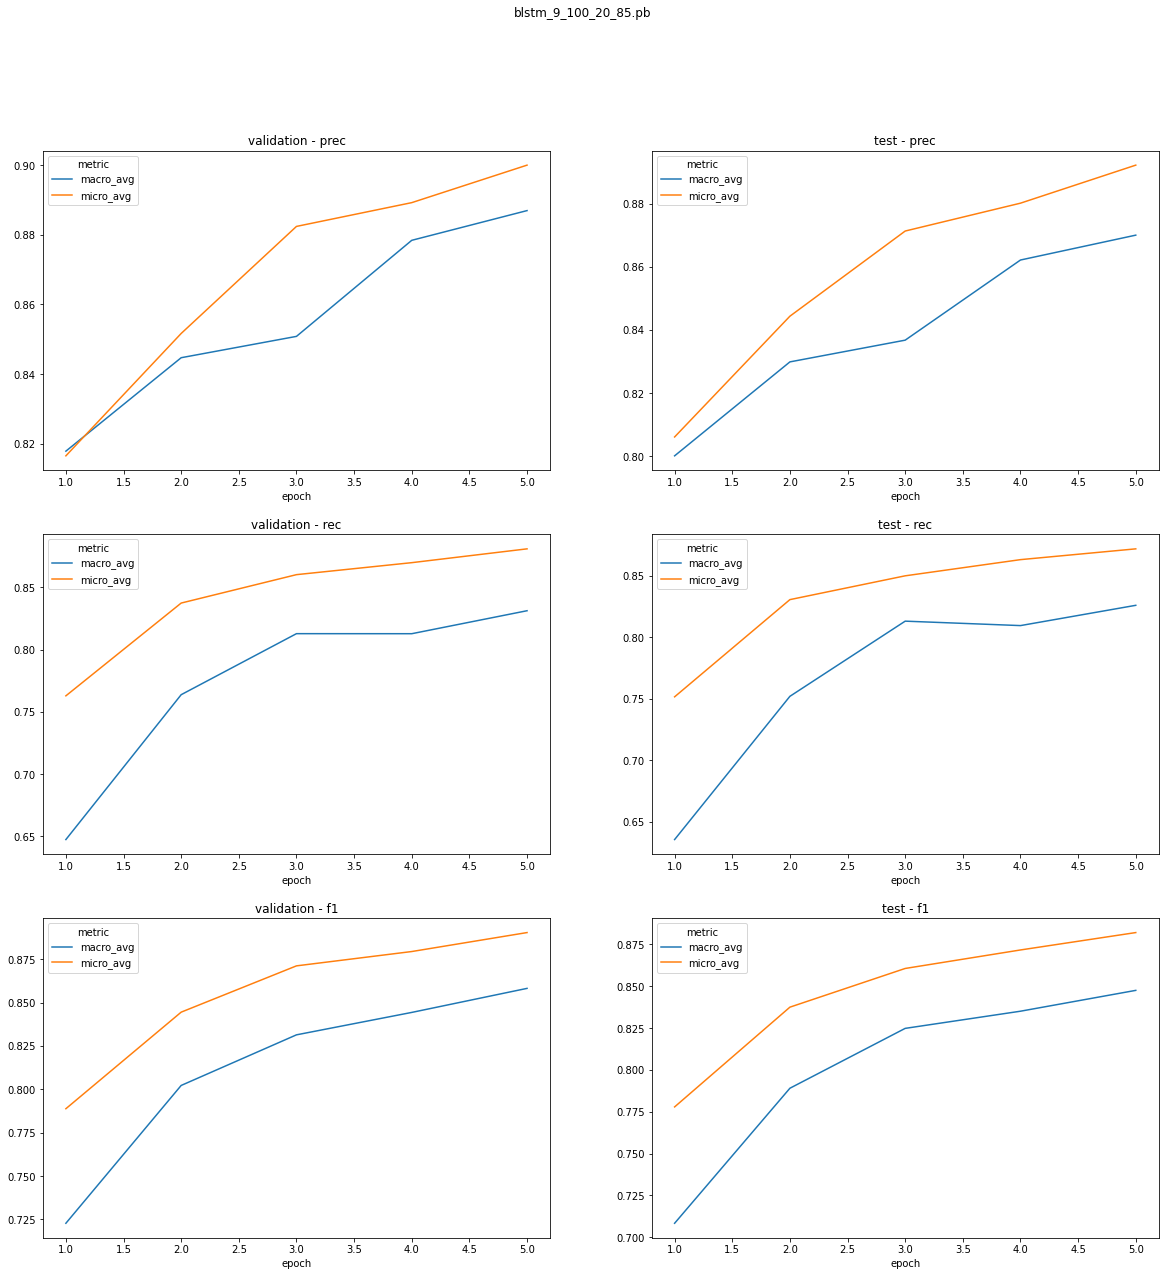

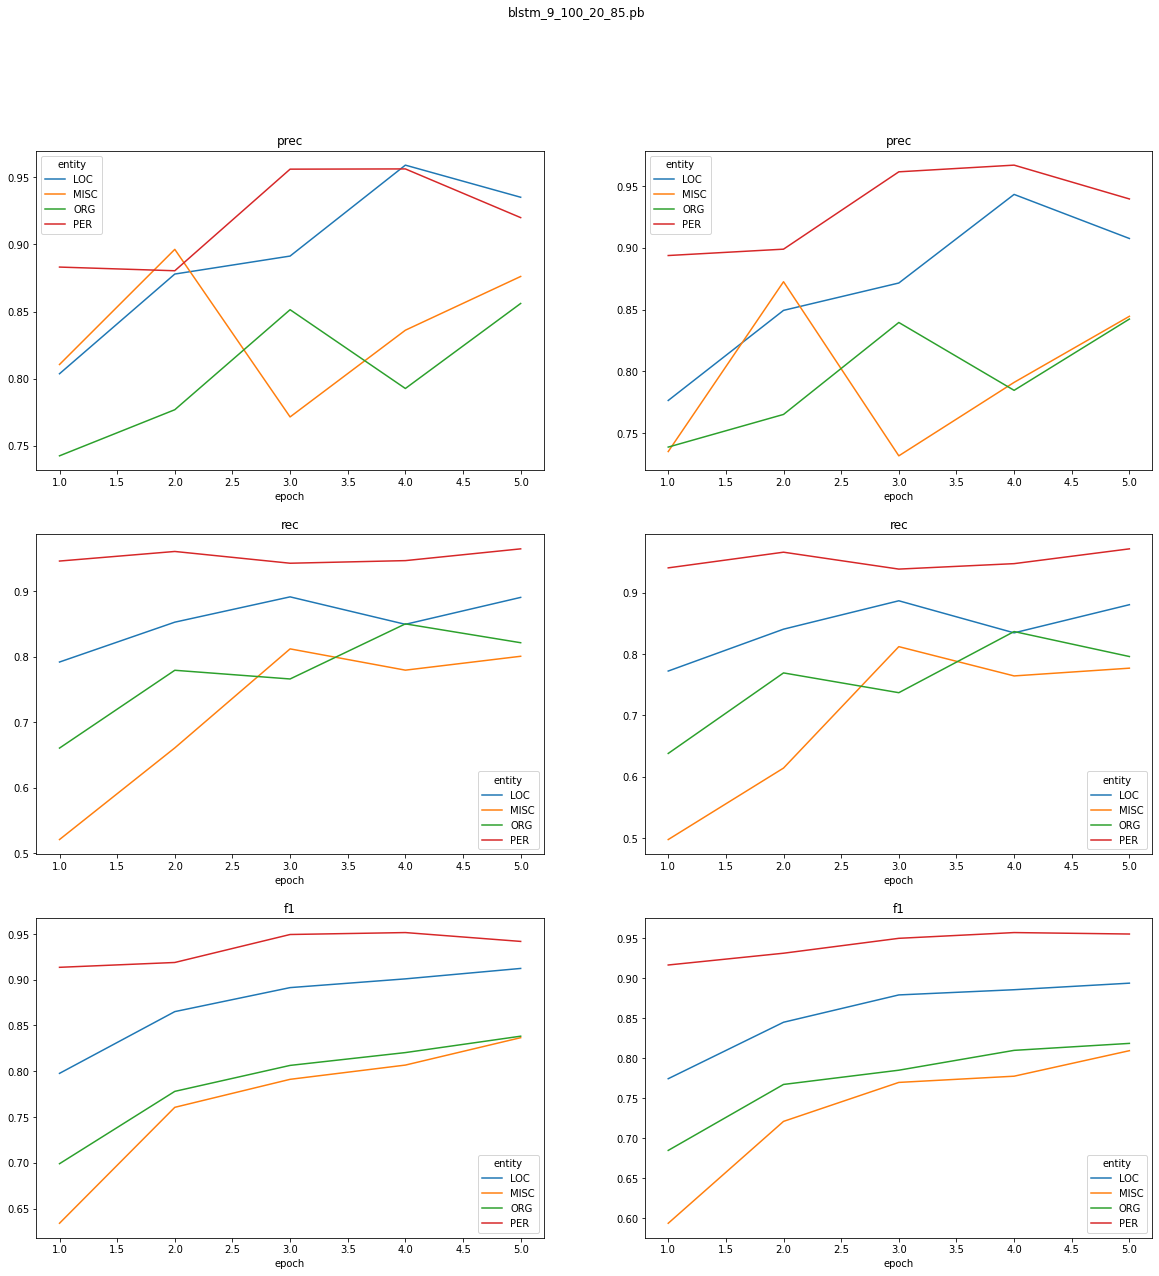

In [0]:
ner_log_parser.get_charts('/dbfs/ner_logs_best/'+log_files[0])

**Plotting Loss**

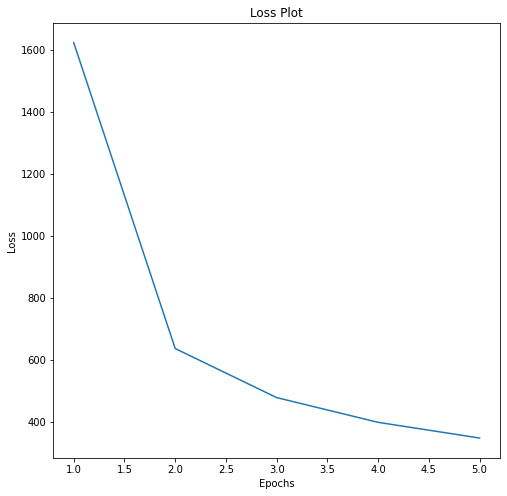

In [0]:
ner_log_parser.loss_plot('/dbfs/ner_logs_best/'+log_files[0])

### Saving the trained model

In [0]:
ner_model.stages

Out[72]: [WORD_EMBEDDINGS_MODEL_48cffc8b9a76,
 TFNerDLGraphBuilderModel_9320414bb925,
 NerDLModel_632873ae432f]

In [0]:
%sh cd /databricks/driver/ && ls -la

total 4864
drwxr-xr-x 1 root root 4096 Oct 11 09:59 .
drwxr-xr-x 1 root root 4096 Oct 11 09:16 ..
drwxr-xr-x 2 root root 4096 Oct 11 09:55 __pycache__
drwxr-xr-x 2 root root 4096 Oct 11 09:14 conf
-rw-r--r-- 1 root root 7431 Oct 11 09:50 conll_eval.py
-rw-r--r-- 1 root root 827443 Oct 11 09:18 eng.testa
-rw-r--r-- 1 root root 3283420 Oct 11 09:18 eng.train
drwxr-xr-x 3 root root 4096 Oct 11 09:16 eventlogs
drwxr-xr-x 2 root root 4096 Oct 11 10:00 ganglia
drwxr-xr-x 2 root root 4096 Oct 11 10:00 logs
-rw-r--r-- 1 root root 3826 Oct 11 09:55 ner_log_parser.py
-rw-r--r-- 1 root root 3826 Oct 11 09:59 ner_log_parser.py.1
-r-xr-xr-x 1 root root 813069 Oct 11 09:14 preload_class.lst

In [0]:
ner_model.stages[-1].write().overwrite().save('dbfs:/databricks/driver/models/NerDLModel_5e32b')

## Prediction Pipeline

In [0]:
document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentence')

token = Tokenizer()\
    .setInputCols(['sentence'])\
    .setOutputCol('token')

glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d')\
    .setInputCols(["document", "token"])\
    .setOutputCol("embeddings")
    
loaded_ner_model = NerDLModel.load("dbfs:/databricks/driver/models/NerDLModel_5e32b")\
     .setInputCols(["sentence", "token", "embeddings"])\
     .setOutputCol("ner")

converter = NerConverter()\
      .setInputCols(["document", "token", "ner"])\
      .setOutputCol("ner_span")

ner_prediction_pipeline = Pipeline(
    stages = [
        document,
        sentence,
        token,
        glove_embeddings,
        loaded_ner_model,
        converter])

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[ | ][OK!]

In [0]:
empty_data = spark.createDataFrame([['']]).toDF("text")

prediction_model = ner_prediction_pipeline.fit(empty_data)


In [0]:
text = "Peter Parker is a nice guy and lives in New York."

sample_data = spark.createDataFrame([[text]]).toDF("text")

sample_data.show(truncate=False)

+-------------------------------------------------+
text |
+-------------------------------------------------+
Peter Parker is a nice guy and lives in New York.|
+-------------------------------------------------+

In [0]:
preds = prediction_model.transform(sample_data)

preds.select(F.explode(F.arrays_zip(preds.ner_span.result,preds.ner_span.metadata)).alias("entities")) \
      .select(F.expr("entities['0']").alias("chunk"),
              F.expr("entities['1'].entity").alias("entity")).show(truncate=False)

+------------+------+
chunk |entity|
+------------+------+
Peter Parker|PER |
New York |LOC |
+------------+------+

In [0]:
from sparknlp.base import LightPipeline

light_model = LightPipeline(prediction_model)

In [0]:
text = "Peter Parker is a nice guy and lives in New York."

result = light_model.annotate(text)

list(zip(result['token'], result['ner']))

Out[80]: [('Peter', 'B-PER'),
 ('Parker', 'I-PER'),
 ('is', 'O'),
 ('a', 'O'),
 ('nice', 'O'),
 ('guy', 'O'),
 ('and', 'O'),
 ('lives', 'O'),
 ('in', 'O'),
 ('New', 'B-LOC'),
 ('York', 'I-LOC'),
 ('.', 'O')]

In [0]:
import pandas as pd

result = light_model.fullAnnotate(text)

ner_df= pd.DataFrame([(int(x.metadata['sentence']), x.result, x.begin, x.end, y.result) for x,y in zip(result[0]["token"], result[0]["ner"])], 
                      columns=['sent_id','token','start','end','ner'])
ner_df

Out[81]:

,sent_id,token,start,end,ner
0,0,Peter,0,4,B-PER
1,0,Parker,6,11,I-PER
2,0,is,13,14,O
3,0,a,16,16,O
4,0,nice,18,21,O
5,0,guy,23,25,O
6,0,and,27,29,O
7,0,lives,31,35,O
8,0,in,37,38,O
9,0,New,40,42,B-LOC


# Creating your own CoNLL dataset

for a detailed overview of how to create a CoNLL file from any annotation, see here >> https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/1.3.prepare_CoNLL_from_annotations_for_NER.ipynb

In [0]:
import json
import os
from pyspark.ml import Pipeline
from sparknlp.base import *
from sparknlp.annotator import *
import sparknlp

spark = sparknlp.start()

def get_ann_pipeline ():
    
    document_assembler = DocumentAssembler() \
        .setInputCol("text")\
        .setOutputCol('document')

    sentence = SentenceDetector()\
        .setInputCols(['document'])\
        .setOutputCol('sentence')
    
    tokenizer = Tokenizer() \
        .setInputCols(["sentence"]) \
        .setOutputCol("token")

    pos = PerceptronModel.pretrained() \
              .setInputCols(["sentence", "token"]) \
              .setOutputCol("pos")
    
    embeddings = WordEmbeddingsModel.pretrained()\
          .setInputCols(["sentence", "token"])\
          .setOutputCol("embeddings")

    ner_model = NerDLModel.pretrained() \
          .setInputCols(["sentence", "token", "embeddings"]) \
          .setOutputCol("ner")

    ner_converter = NerConverter()\
      .setInputCols(["sentence", "token", "ner"])\
      .setOutputCol("ner_chunk")

    ner_pipeline = Pipeline(
        stages = [
            document_assembler,
            sentence,
            tokenizer,
            pos,
            embeddings,
            ner_model,
            ner_converter
        ]
    )

    empty_data = spark.createDataFrame([[""]]).toDF("text")

    ner_pipelineFit = ner_pipeline.fit(empty_data)

    ner_lp_pipeline = LightPipeline(ner_pipelineFit)

    print ("Spark NLP NER lightpipeline is created")

    return ner_lp_pipeline


conll_pipeline = get_ann_pipeline()



pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[ | ][ / ][ — ][OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[ | ][OK!]
ner_dl download started this may take some time.
Approximate size to download 13.6 MB
[ | ][ / ][ — ][OK!]
Spark NLP NER lightpipeline is created

In [0]:
sentences = ["Peter Parker is a nice guy and lives in New York.",
"He is also helping people around the world."]

conll_lines=''

for sentence in sentences:

  parsed = conll_pipeline.annotate (sentence)

  for token, pos, ner in zip(parsed['token'],parsed['pos'],parsed['ner']):

      conll_lines += "{} {} {} {}\n".format(token, pos, pos, ner)

  conll_lines += '\n'


print(conll_lines)

Peter NNP NNP B-PER
Parker NNP NNP I-PER
is VBZ VBZ O
a DT DT O
nice JJ JJ O
guy NN NN O
and CC CC O
lives NNS NNS O
in IN IN O
New NNP NNP B-LOC
York NNP NNP I-LOC
. . . O

He PRP PRP O
is VBZ VBZ O
also RB RB O
helping VBG VBG O
people NNS NNS O
around IN IN O
the DT DT O
world NN NN O
. . . O

End of Notebook #